In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [35]:
import numpy as np

import sys
sys.path.append('../scripts/')

from proj1_helpers import *
from implementations import *
from implementation_variants import *
from plots import *

SEED = 42
DATA_PATH = '../data/'

# 0 Load data

In [6]:
(y_train, x_train, tx_train), (y_eval, x_eval, tx_eval), (y_test, x_test, tx_test, ids_test) = load_data(DATA_PATH)

print(f' # train samples: {len(y_train)}\n # eval samples: {len(y_eval)}\n # test samples: {len(y_test)}')

 # train samples: 175000
 # eval samples: 75000
 # test samples: 568238


# 1 Random baseline guessing

In [7]:
# Get baseline frequency of the two classes in training data
prior_probs = [sum(y_train == 1)/len(y_train), sum(y_train == 0)/len(y_train)]

# Test error on evaluation set
y_eval_pred = np.random.choice([1., 0], size=len(y_eval), p=prior_probs)

acc_baseline = get_accuracy(y_eval_pred, y_eval)
f1_baseline = get_f1_score(y_eval_pred, y_eval)

print('Accuracy Baseline {}'.format(acc_baseline))
print('F1 Baseline {}'.format(f1_baseline))

# Save in submission file
y_test_pred = np.random.choice([1., -1.], size=len(y_test), p=prior_probs)
create_csv_submission(ids_test, y_test_pred, '../data/random_baseline_submission.csv')

Accuracy Baseline 0.5487733333333333
F1 Baseline 0.5091589861751152


The accuracy on the test after submission to the AICrowd platform for the random guess model is 55%. This is thus our baseline. Anything that goes below that is probably overfitting or a model that diverged. 

# 1 Least-squares

## 1.1 Least-squares (normal equations) 

In [8]:
# Get linear least-squares model
w_ls, mse_ls = least_squares(y_train, x_train)

# Get accuracy on evaluation set
acc_ls = eval_model(y_eval, x_eval, w_ls, thresh=0)
print(f'Accuracy: {acc_ls}')

Accuracy: 0.7193733333333333


## 1.2 Least-squares gradient descent 

In [9]:
# Define hyperparameters for gradient descent
max_iters = 1000
gamma = .05

# Initial weights vector to train a linear model
w_initial = np.zeros(x_train.shape[1])

# Run gradient descent under MSE loss to find optimal weights
w_GD, mse_GD = least_squares_GD(y_train, x_train, w_initial, max_iters, gamma)

In [10]:
acc_ls_gd = eval_model(y_eval, x_eval, w_GD, thresh=0)
print(f'Accuracy: {acc_ls_gd}')

Accuracy: 0.71844


Accuracy on evaluation set very similar so GD seems to find a good solution

## 1.3 Least-squares SGD

In [11]:
# Define hyperparameters for gradient descent
max_iters = 1000
gamma = .05

# Initial weights vector to train a linear model
w_initial = np.zeros(x_train.shape[1])

# Run gradient descent under MSE loss to find optimal weights
w_SGD, mse_SGD = least_squares_SGD(y_train, x_train, w_initial, max_iters, gamma)

In [14]:
acc_ls_sgd = eval_model(y_eval, x_eval, w_SGD, thresh=0)
print(f'Accuracy: {acc_ls_sgd}')

Accuracy: 0.5207066666666667


Does not yield very satisfactor result. Could run some hyperparameter optimisation to get better results. 

# 2 Ridge regression

## 2.1 Hyperparameter optimisation 

Maximum test accuracy 0.7180228571428571 with lambda 2.3357214690901212e-07


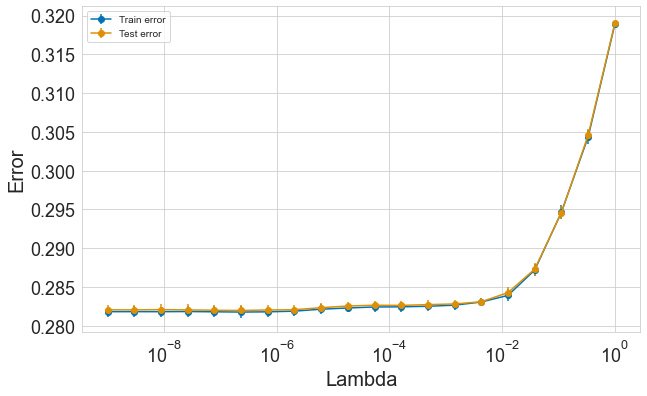

In [17]:
lambdas = np.logspace(-9, 0, 20)
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(lambdas), k_fold), float)
acc_test = np.empty((len(lambdas), k_fold), float)

for l, lambda_ in enumerate(lambdas):
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
        # Train
        w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
        acc_tr = eval_model(train_split[1], train_split[0], w)
        acc_train[l, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w)
        acc_test[l, k] = acc_te

        k += 1
fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

avg_acc_test = np.mean(acc_test, axis=1)
lambda_opt = lambdas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt))

## 2.2 Ridge regression training

In [18]:
# Run training
w_ridge, loss_ridge = ridge_regression(y_train, x_train, lambda_opt)
acc = eval_model(y_train, x_train, w_ridge)
print(f'Training accuracy: {acc}')

acc_ridge = eval_model(y_eval, x_eval, w_ridge)
print(f'Test accuracy: {acc_ridge}')

Training accuracy: 0.7181542857142857
Test accuracy: 0.71924


# 3 Lasso regression

## 3.1 Hyperparameter optimisation

Maximum test accuracy 0.7174571428571429 with lambda 2.3357214690901212e-07


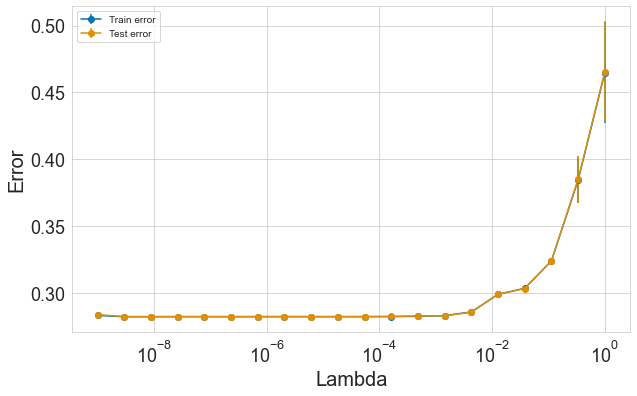

In [19]:
max_iters = 1000
gamma = 0.01
w_initial = np.zeros(x_train.shape[1])

lambdas = np.logspace(-9, 0, 20)
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(lambdas), k_fold), float)
acc_test = np.empty((len(lambdas), k_fold), float)

for l, lambda_ in enumerate(lambdas):
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
        # Train
        w, loss = lasso_GD(train_split[1], train_split[0], w_initial, max_iters, gamma, lambda_)
        acc_tr = eval_model(train_split[1], train_split[0], w)
        acc_train[l, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w)
        acc_test[l, k] = acc_te

        k += 1
fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

avg_acc_test = np.mean(acc_test, axis=1)
lambda_opt = lambdas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt))

## 3.2 Lasso regression training

In [20]:
# Find optimal ridge regression model under lambda_opt
gamma = 0.01
max_iter = 1000
w_initial = np.zeros(x_train.shape[1])

# Run training
w_lasso, loss_lasso = lasso_GD(y_train, x_train, w_initial, max_iters, gamma, lambda_opt)
acc = eval_model(y_train, x_train, w_lasso)
print(f'Training accuracy: {acc}')

acc_lasso = eval_model(y_eval, x_eval, w_lasso)
print(f'Test accuracy: {acc_lasso}')

Training accuracy: 0.71416
Test accuracy: 0.71544


# 4 Logistic Regression 

In [34]:
gamma = 1e-5
max_iters = 10000
w_initial = np.ones(tx_train.shape[1])

# Run gradient descent 
w_lr, loss_lr = logistic_regression(y_train, tx_train, w_initial, max_iters, gamma, verbose=True)
acc = eval_model(y_train, tx_train, w_lr, thresh=0.5)
print(f'Training accuracy: {acc}')

acc_lr = eval_model(y_eval, tx_eval, w_lr, thresh=0.5)
print(f'Testing accuracy: {acc_lr}')

Gradient Descent (0/9999): loss=522981.6237341607, gradient=202236.4372335119
Gradient Descent (1000/9999): loss=131939.2064034755, gradient=124073.67478111768
Gradient Descent (2000/9999): loss=131937.54019656926, gradient=124069.56900252018
Gradient Descent (3000/9999): loss=131935.7401362967, gradient=124069.26370162486
Gradient Descent (4000/9999): loss=131934.00430845094, gradient=124068.99499451798
Gradient Descent (5000/9999): loss=131932.33878975356, gradient=124068.72334627689
Gradient Descent (6000/9999): loss=131930.73880863178, gradient=124068.44923433644
Gradient Descent (7000/9999): loss=131929.19980990177, gradient=124068.17352508674
Gradient Descent (8000/9999): loss=131927.71759416378, gradient=124067.8969110196
Gradient Descent (9000/9999): loss=131926.28829233284, gradient=124067.61993505426
Training accuracy: 0.7023257142857143
Testing accuracy: 0.7004266666666666


## 4.1 Logistic Regression with mean NLL

In [ ]:
gamma = 1e-5
max_iters = 10000
w_initial = np.ones(tx_train.shape[1])

# Run gradient descent 
w_lr, loss_lr = logistic_regression_GD(y_train, tx_train, w_initial, max_iters, gamma, verbose=True)
acc = eval_model(y_train, tx_train, w_lr, thresh=0.5)
print(f'Training accuracy: {acc}')

acc_lr = eval_model(y_eval, tx_eval, w_lr, thresh=0.5)
print(f'Testing accuracy: {acc_lr}')

Gradient Descent (0/9999): loss=5.250533171570391, gradient=1.1556367841914965


# 5 Regularised logistic regression 

In [29]:
lambdas = np.logspace(-7, 0, 20)
k_fold = 4

max_iters = 1000
gamma = 1e-5
w_initial = np.ones(tx_train.shape[1])

# Hyperparameter optimisation
acc_train = np.empty((len(lambdas), k_fold), float)
acc_test = np.empty((len(lambdas), k_fold), float)

for l, lambda_ in enumerate(lambdas):
    k = 0
    for train_split, test_split in k_fold_iter(y_train, tx_train, k_fold):
        # Train
        w, loss = reg_logistic_regression(train_split[1], train_split[0], lambda_, 
                                      w_initial, max_iters, gamma, verbose=False)
        acc_tr = eval_model(train_split[1], train_split[0], w, thresh=0.5)
        acc_train[l, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w, thresh=0.5)
        acc_test[l, k] = acc_te

        k += 1
fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

avg_acc_test = np.mean(acc_test, axis=1)
lambda_opt_lr = lambdas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_lr))

KeyboardInterrupt: 

In [ ]:
gamma = 0.0001
max_iters = 10000
w_initial = np.zeros(tx_train.shape[1])

# Run training
w_lr_reg, loss = reg_logistic_regression(y_train, tx_train, lambda_opt_lr, 
                                         w_initial, max_iters, gamma, verbose=True)
acc = eval_model(y_train, tx_train, w_lr_reg)
print(f'Training accuracy: {acc}')

acc_lr_reg = eval_model(y_eval, tx_eval, w_lr_reg)
print(f'Test accuracy: {acc_lr_reg}')

# 6 Model comparison

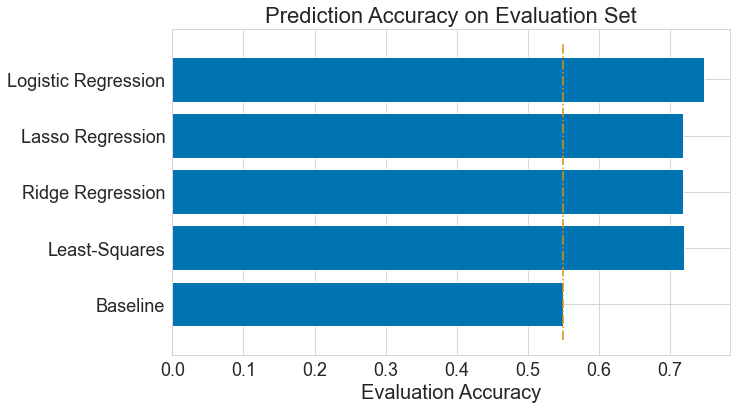

In [306]:
accuracy = [acc_baseline, acc_ls, acc_ridge, acc_lasso, acc_lr]
labels = ['Baseline', 'Least-Squares', 'Ridge Regression', 'Lasso Regression', 'Logistic Regression']

fig, ax = plt.subplots(figsize=(10,6))

ax.barh([i for i in range(len(accuracy))], accuracy)
ax.vlines(acc_baseline, *ax.get_ylim(), colors=COLOURS[1], linestyle='-.')

ax.set(title='Prediction Accuracy on Evaluation Set', xlabel='Evaluation Accuracy',
       yticks=[i for i in range(len(labels))], yticklabels=labels);

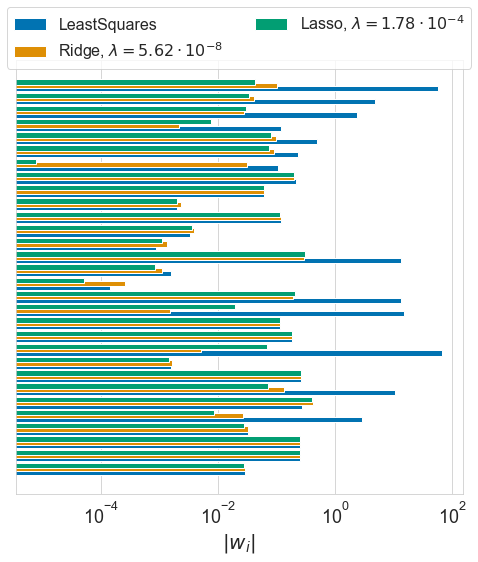

In [256]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log')
ax.barh([i*2 for i in range(num_dim)], abs(w_ls), label='LeastSquares')
ax.barh([i*2+.5 for i in range(num_dim)], abs(w_ridge), label='Ridge, $\lambda = 5.62 \cdot 10^{-8}$')
ax.barh([i*2+1 for i in range(num_dim)], abs(w_lasso), label='Lasso, $\lambda = 1.78 \cdot 10^{-4}$')

ax.legend(fontsize=16, loc='center', bbox_to_anchor=(.5,1.05), ncol=2)

ax.set(yticks=[], xlabel='$|w_i|$');